# 3. Generating exam-like Questions with the help of LLMs
In this Notebook we will use the free [Github Marketplace Models](https://github.com/marketplace?type=models) to come up with some exam-like questions about the BIDS lecture Slides. Be aware that those are [limited to 50 request per day](https://docs.github.com/en/github-models/use-github-models/prototyping-with-ai-models#rate-limits) for most of the models. 

To use the Models you have to set a Github Token (as explained in the [ReadMe file](README.md).

In [1]:
import os
from openai import OpenAI

# Setting up the model
endpoint = "https://models.inference.ai.azure.com"
token = os.environ["GITHUB_TOKEN"]
model = "gpt-4.1"

client = OpenAI(base_url=endpoint,api_key=token)

### Using the RAG-search to find Slides that match a certain topic you would like to generate a question about

In [2]:
from byaldi import RAGMultiModalModel

question_topic = "Different Segemantation Methods"

# Send the question to the RAG model to get most relevant slides
RAG = RAGMultiModalModel.from_index("BIDS_index", device='cpu')
results = RAG.search(question_topic, k=5)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 733 images from 2 JSON files.


### Now send the Images to the Model and prompt it to generate some exam-like questions about the slides contents

In [3]:
num_questions = 3
prompt = (f"Take a look at the slides and generate exactly {num_questions} questions for college students that can be answered with the help of the Slides."
f"Slides are from a Bioimage Analysis Lecture. Output ONLY the questions, no other explanations/ information. The general topic is {question_topic}."
f"Output style should be:"
f" 1. question1"
f" 2. question2 ...")

In [4]:
# Start with text content
message_content = [{"type": "text", "text": prompt}]

# Add images
for result in results:  
    base64_img = result["base64"]
    message_content.append({
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{base64_img}"
        }
    })

# Now wrap into full message structure
messages = [
    {"role": "system", "content": "You are a data scientist specializing in image analysis."},
    {"role": "user", "content": message_content}
]

# Example OpenAI call
response = client.chat.completions.create(
    model=model,
    messages=messages
)

In [5]:
print(response.choices[0].message.content)

1. What is the difference between instance segmentation and semantic segmentation, based on the example images shown in the slides?
2. How does sparse annotation differ from full annotation in both instance and semantic segmentation, as illustrated in the recap slides?
3. Which deep learning networks are mentioned for segmentation tasks in microscopy images, and how do their input and output images differ?


### Now we have the questions and can figure out an answer on out own.
To check the answer we can now visualize the corresponding images and check its information.

In [6]:
from PIL import Image
import base64
from io import BytesIO

# Reconstruct the Images from the resulting Slides
reconstructed_images = []

for result in results:
    base64_img = result["base64"]  
    image_data = base64.b64decode(base64_img)
    image = Image.open(BytesIO(image_data))
    reconstructed_images.append(image)

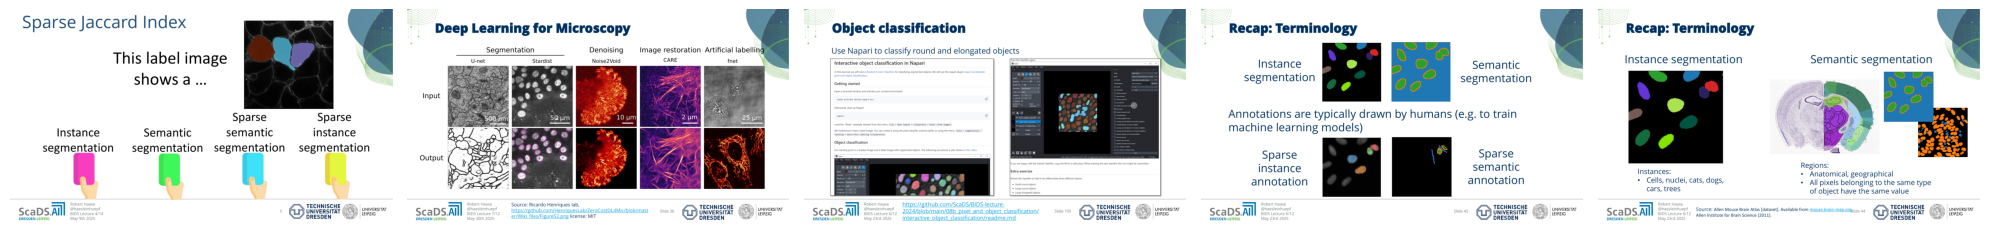

In [7]:
import matplotlib.pyplot as plt

# Visualize the Slides that best match to the query
fig, axes = plt.subplots(1, len(reconstructed_images), figsize=(20, 8))

for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()